In [4]:
from gpytorch.models import ExactGP
from gpytorch.distributions import MultivariateNormal

class PriorGP(ExactGP):
    def __init__(self, mean_module, covar_module, likelihood, train_x=None, train_y=None):
        super(PriorGP, self).__init__(train_x, train_y, likelihood)
        self.mean_module = mean_module
        self.covar_module = covar_module

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

In [5]:
import numpy as np
import torch
from math import pi

class GaussianProcessPriorSampler():
    def __init__(self, model, x_dim=1, num_of_bases=1024, num_of_samples=1):
        self.model = model
        self.x_dim = x_dim
        self.lengthscale = self.model.covar_module.base_kernel.lengthscale.detach().float()
        self.outputscale = self.model.covar_module.outputscale.item()
        self.kernel = self.model.covar_module
        self.num_of_bases = num_of_bases
        self.num_of_samples = num_of_samples
        self.create_fourier_bases()

    def create_fourier_bases(self):
        # sample thetas
        self.thetas = torch.randn(size = (self.num_of_bases, self.x_dim)) / self.lengthscale
        # sample biases
        self.biases = torch.rand(self.num_of_bases) * 2 * pi

    def calculate_fourier_features(self, x):
        '''
        Calculate the Fourier Features evaluated at some input x
        '''
        # # evaluation using fourier features
        # self.posterior_update(x)
        # calculate the dot product between the frequencies, theta, and the new query points
        dot = x.matmul(self.thetas.T)
        # calculate the fourier frequency by adding bias and cosine
        ft = torch.cos(dot + self.biases.unsqueeze(0))
        # apply the normalising constants and return the output
        return self.outputscale * np.sqrt(2 / self.num_of_bases) * ft

    def create_sample(self):
        # sample weights
        self.weights = torch.randn(size = (self.num_of_samples, self.num_of_bases)).float()

    def sample_prior(self, x):
        '''
        Create a sample from the prior, evaluate it at x
        '''
        if type(x) is not torch.Tensor:
            x = torch.tensor(x)
        # calculate the fourier features evaluated at the query points
        out1 = self.calculate_fourier_features(x)
        # extend the weights so that we can use element wise multiplication
        weights = self.weights.repeat(x.shape[0], 1)
        # return the prior
        return torch.sum(weights * out1, axis = -1)

    def query_sample(self, x):
        '''
        Query the sample at a location
        '''
        prior = self.sample_prior(x)
        return prior

Text(0, 0.5, 'Y')

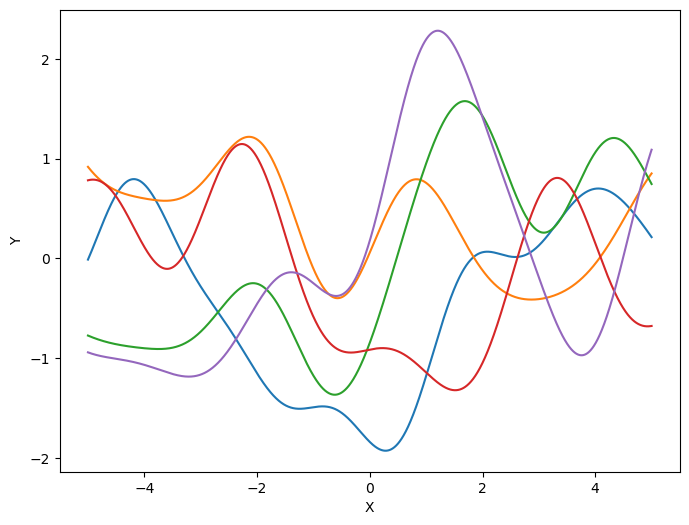

In [8]:
from gpytorch.likelihoods import FixedNoiseGaussianLikelihood
from gpytorch.means import ZeroMean
from gpytorch.kernels import ScaleKernel, RBFKernel
import matplotlib
from matplotlib import pyplot as plt

# Define a Prior GP model
mean_module = ZeroMean()
covar_module = ScaleKernel(RBFKernel())
likelihood = FixedNoiseGaussianLikelihood(noise=1e-4*torch.ones(1))
model = PriorGP(mean_module, covar_module, likelihood)
model.covar_module.outputscale = 1.0
model.covar_module.base_kernel.lengthscale = 1.0
model.eval()

# Create a GP Prior Sampler that can draw smooth samples from model using Fourier feature expansion
nx = 1
gpsampler = GaussianProcessPriorSampler(model, nx)

# Plot the results to visualize
# plt.figure(figsize=(8,6))
# n_samples = 5
# for i in range(n_samples):
#     gpsampler.create_sample()
#     X = torch.linspace(-5, 5, 5001).unsqueeze(-1)
#     Y = gpsampler.query_sample(X)
#     plt.plot(X.detach().numpy(), Y.detach().numpy())
# plt.xlabel('X')
# plt.ylabel('Y')

# Below code is the modification for BONSAI

In [10]:
a =torch.rand(100,2)

In [13]:
gpsampler.query_sample(a)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x2 and 1x1024)